# Exploration of the preprocessed MySeizureGauage data

*Author: Jozsef KOVACS*
*Created: 25/05/2024*

This notebook contains some elements of the exploratory analysis related to the My Seizure Gauge dataset, executed on the preprocessed data (preprocessing that occurs in my **msg-e4** project, before the LSTM-based classfier is trained to conduct seizure forecasting.

The original input channels (8) acquired from the Empatica-E4 wristband are:
- BVP: Blood Volume Pulse,
- TEMP: skin temperature,
- EDA: Electrodermal activity,
- HR: Heart rate,
- ACCMag: Accelerometry - signal from accelerometer: magnitude
- ACCx, ACCy, ACCz: Accelerometry - values for x, y and z axes
The available raw data has already been upsampled to a unified rate of 128 Hz.

The above channels are extended by: 
- SQI for the EDA channel: rate of amplitude change in concurrent 1-s windows (more than 0.2 increase, or 0.1 decrease are considered artefacts),
- SQI for the BVP channel: spectral entropy is calculated for 1-min segments averaged over 4-s windows (under 0.9 is considered good quality),
- RMS of the ACC data: spectral power of narrowband physiological (0.8-5 Hz) and broadband (0.8Hz to Nyquist frequency) for non-overlaping 4-s segments, average over consecutive 1-min segments.

Furthermore, Short-time Fourier Transform is calculated for the BVP, TEMP, EDA, HR and ACCMag channels (onesided, PSD-scale), using a window of 512 frames with an overlap of 384), with applying max-pooling on the results frequency dimension of size 8.

Hour-of-the-day is not added to the features, because the data is not from a long-term or ultra-long-term monitoring study. Most of the available data is covering only a short period of time (few days, in some cases less). Consequently, there are only few lead seizures (leas than 5). This does not allow for learning useful patterns from the circadian rhytm (it could be severly misleading in the evaluation).

The final input dimension has 176 features for every frame.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import os
from glob import glob
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from umap import UMAP
import umap.plot


/system/user/kovacs/miniconda3/envs/wearfc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/system/user/kovacs/miniconda3/envs/wearfc/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/system/user/kovacs/miniconda3/envs/wearfc/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
PREPROC_DIR = '/system/user/studentwork/kovacs/seer-msg/preproc'

feature_names = ['BVP', 'TEMP', 'EDA', 'HR', 'ACC_Mag', 'ACC_x', 'ACC_y', 'ACC_z']
feature_names += [ f'stft_{ch}_{i+1}' for ch in ['BVP', 'TEMP', 'EDA', 'HR', 'ACC_Mag'] for i in range(33)]
feature_names += ['SQI_EDA', 'SQI_BVP', 'SQI_ACC']
feature_names_df = pd.DataFrame(feature_names, columns=['feature_name'])

In [24]:
def load_dataset(preproc_dir, subject_id, split_folder, dataset_type='train', sampling_freq=128, sequence_length=60, input_size=176):
    feature_list, target_list = [], []
    preictal_cnt = 0
    interictal_cnt = 0
    pp_meta = pd.read_csv(preproc_dir / Path(subject_id) / Path(split_folder) / 'pp_metadata.csv')
    for data_type, label in [(f'preictal_{dataset_type}', 1.), (f'interictal_{dataset_type}', 0.)]:
        for file in pp_meta['filename'][pp_meta['type'] == data_type]:
            if data_type == f'preictal_{dataset_type}':
                preictal_cnt += 1
            else:
                interictal_cnt += 1
            print(f"processing: {file}")
            df = pd.read_hdf(file, key='df', mode='r')
            a = np.array(df, dtype=np.float32)
            mult = sampling_freq
            a = np.nan_to_num(a.reshape(-1, mult * sequence_length, input_size))
            feature_list.append(a)
            target_list += [label] * a.shape[0]
    
    # initialize superclass with features & labels
    return np.vstack(feature_list), np.asarray(target_list)

In [34]:
features, labels = load_dataset(PREPROC_DIR, 'MSEL_00764', 'split_000') 

processing: /system/user/studentwork/kovacs/seer-msg/preproc/MSEL_00764/split_000/preictal_train/preictal_train_001.h5
processing: /system/user/studentwork/kovacs/seer-msg/preproc/MSEL_00764/split_000/preictal_train/preictal_train_002.h5
processing: /system/user/studentwork/kovacs/seer-msg/preproc/MSEL_00764/split_000/preictal_train/preictal_train_003.h5
processing: /system/user/studentwork/kovacs/seer-msg/preproc/MSEL_00764/split_000/preictal_train/preictal_train_004.h5
processing: /system/user/studentwork/kovacs/seer-msg/preproc/MSEL_00764/split_000/preictal_train/preictal_train_005.h5
processing: /system/user/studentwork/kovacs/seer-msg/preproc/MSEL_00764/split_000/preictal_train/preictal_train_006.h5
processing: /system/user/studentwork/kovacs/seer-msg/preproc/MSEL_00764/split_000/preictal_train/preictal_train_007.h5
processing: /system/user/studentwork/kovacs/seer-msg/preproc/MSEL_00764/split_000/preictal_train/preictal_train_008.h5
processing: /system/user/studentwork/kovacs/seer

In [27]:
colors = [('hotpink' if l == 1. else 'royalblue') for l in labels]

In [28]:
# auxiliary function to plot charts by features
def overview_plot(data, plt_type, colors=None, size=5, only_features=None):
    num_features = data.shape[2] 
    num_cols = 5
    num_rows = num_features // num_cols + (num_features % num_cols > 0)
    fig_size = (20, num_rows * 4)
    fig, ax = plt.subplots(num_rows, num_cols, figsize=fig_size)

    for feature_idx in range(num_rows * num_cols):
        axp = ax[feature_idx // num_cols, feature_idx % num_cols]
        if feature_idx < num_features:
            if plt_type == 'mean_std':
                axp.scatter(np.mean(data[:, :, feature_idx], axis=1), np.std(data[:, :, feature_idx], axis=1), s=size, c=colors)
            elif plt_type == 'feature_hist':
                axp.hist(np.mean(data[:, feature_idx, :], axis=1), bins="auto")
            elif plt_type == 'boxplot':
                axp.boxplot(np.mean(data[:, feature_idx, :], axis=1), notch=True, patch_artist=True)
                axp.yaxis.grid(True)                
            axp.set_title(feature_names_df.iloc[feature_idx]['feature_name'])
        else:
            fig.delaxes(axp)
        

    fig.tight_layout()
    plt.show()

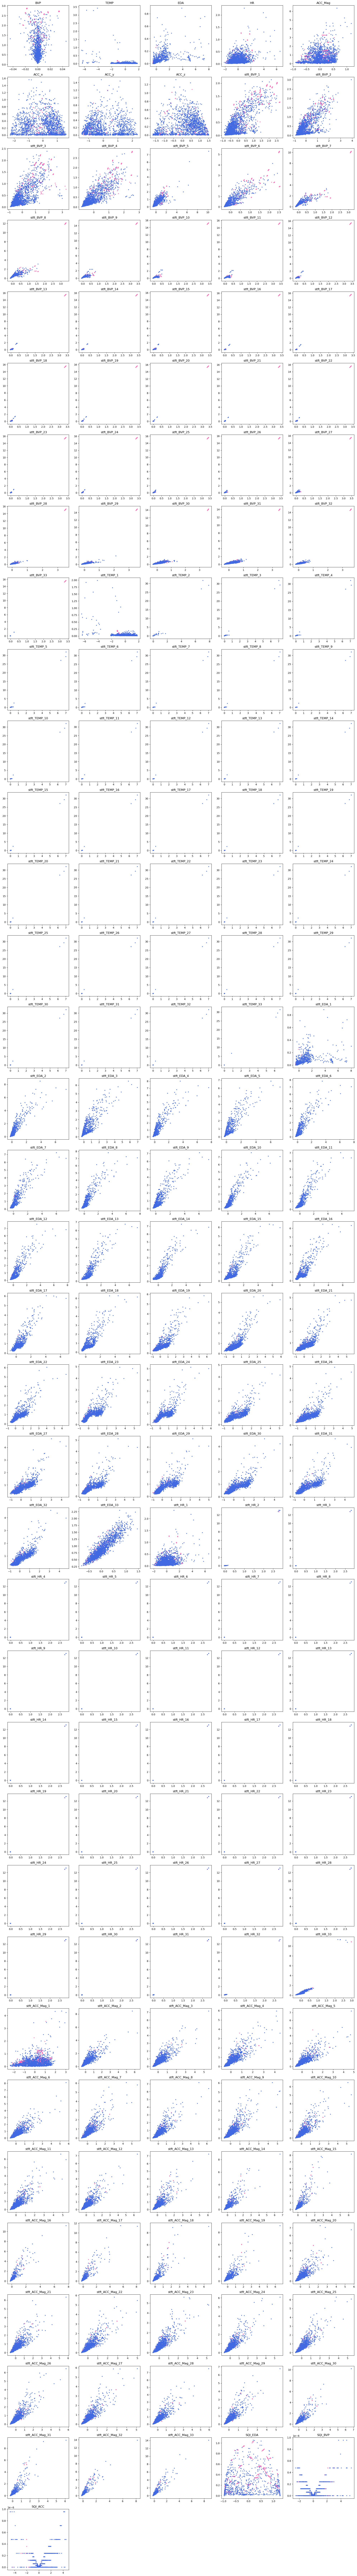

In [29]:
overview_plot(features, 'mean_std', colors=colors)

In [30]:
f_mu = np.mean(features, axis=1)
f_std = np.std(features, axis=1)

In [31]:
rfc = RandomForestClassifier(n_estimators=100, random_state=76)
rfc.fit(f_mu, labels)
#rf_pred = rf[(feature_req, dim_reduce, n_estim)].predict(X_valid)

RandomForestClassifier(random_state=76)

In [32]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[-10:]
feature_names_df.iloc[indices]['feature_name']

23     stft_BVP_16
33     stft_BVP_26
81      stft_EDA_8
98     stft_EDA_25
173        SQI_EDA
92     stft_EDA_19
41     stft_TEMP_1
1             TEMP
2              EDA
74      stft_EDA_1
Name: feature_name, dtype: object

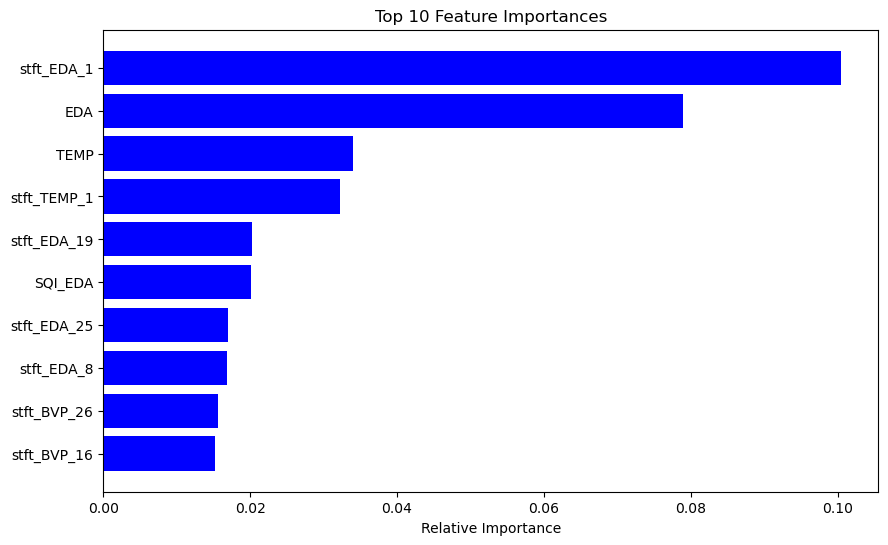

In [33]:
importances = rfc.feature_importances_

indices = np.argsort(importances)[-10:]

# Visualize Feature Importances
plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), feature_names_df.iloc[indices]['feature_name'])
plt.xlabel('Relative Importance')
plt.show()

In [151]:
features_test, labels_test = load_dataset(PREPROC_DIR, 'MSEL_01870', 'split_000', dataset_type='test') 

processing: /system/user/studentwork/kovacs/seer-msg/preproc/MSEL_01870/split_000/preictal_test/preictal_test_001.h5
processing: /system/user/studentwork/kovacs/seer-msg/preproc/MSEL_01870/split_000/interictal_test/interictal_test_001.h5
processing: /system/user/studentwork/kovacs/seer-msg/preproc/MSEL_01870/split_000/interictal_test/interictal_test_002.h5
processing: /system/user/studentwork/kovacs/seer-msg/preproc/MSEL_01870/split_000/interictal_test/interictal_test_003.h5
processing: /system/user/studentwork/kovacs/seer-msg/preproc/MSEL_01870/split_000/interictal_test/interictal_test_004.h5
processing: /system/user/studentwork/kovacs/seer-msg/preproc/MSEL_01870/split_000/interictal_test/interictal_test_005.h5
processing: /system/user/studentwork/kovacs/seer-msg/preproc/MSEL_01870/split_000/interictal_test/interictal_test_006.h5
processing: /system/user/studentwork/kovacs/seer-msg/preproc/MSEL_01870/split_000/interictal_test/interictal_test_007.h5
processing: /system/user/studentwork

In [152]:
ftest_mu = np.mean(features_test, axis=1)
ftest_std = np.std(features_test, axis=1)

In [153]:
rfc_pred = rfc.predict(ftest_mu)

In [154]:
accuracy_score(labels_test, rfc_pred)

0.8073529411764706

In [155]:
f1_score(labels_test, rfc_pred, average='weighted')

0.8671325324271286

In [156]:
sum(labels_test == rfc_pred)

1647

In [169]:
ftest_mu.shape

(2040, 176)

In [22]:
umap_model = UMAP(n_components=2, n_neighbors=50, metric='cosine', random_state=42, n_epochs=500)
mapper = umap_model.fit(np.mean(features[:, :, [indices]], axis=1).squeeze())  
#mapper = umap_model.fit(np.mean(features[:, :, :], axis=1).squeeze())  

/system/user/kovacs/miniconda3/envs/wearfc/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: >

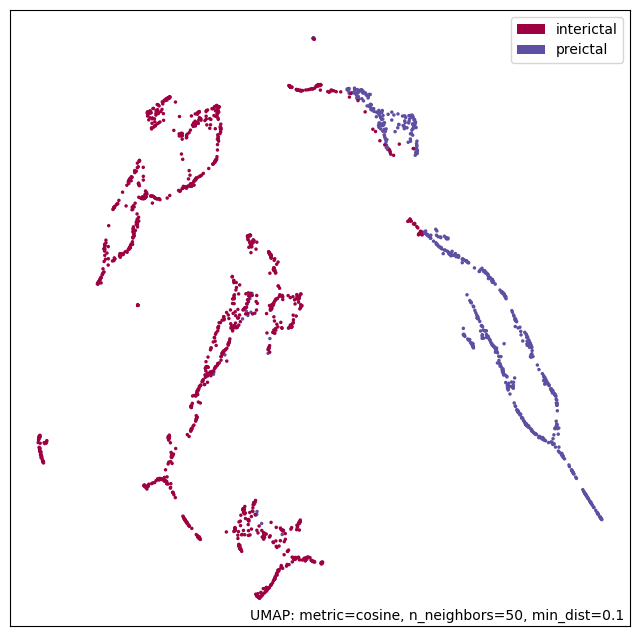

In [23]:
umap.plot.points(mapper, labels=pd.DataFrame([('preictal' if l == 1.0 else 'interictal') for l in labels], columns=['label'])['label'])